Overview: Interferometer
------------------------

Alongside CCD `Imaging` data, **PyAutoLens** supports the modeling of interferometer data from submillimeter and radio
observatories. The dataset is fitted directly in the uv-plane, circumventing issues that arise when fitting a `dirty
image` such as correlated noise.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt
from os import path
import numpy as np

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


To begin, we load an interferometer dataset from fits files:

Load the strong lens interferometer dataset `mass_sie__source_sersic` `from .fits files, which is the dataset 
we'll use in this example.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "interferometer", dataset_name)

interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
)

The PyAutoLens plot module has tools for plotting interferometer datasets, including the visibilities, noise-map
and uv wavelength which represent the interferometer`s baselines. 

The data used in this tutorial contains 1 million visibilities and is representative of an ALMA dataset:

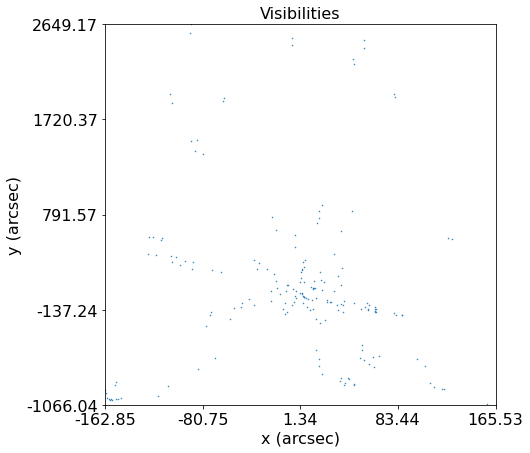

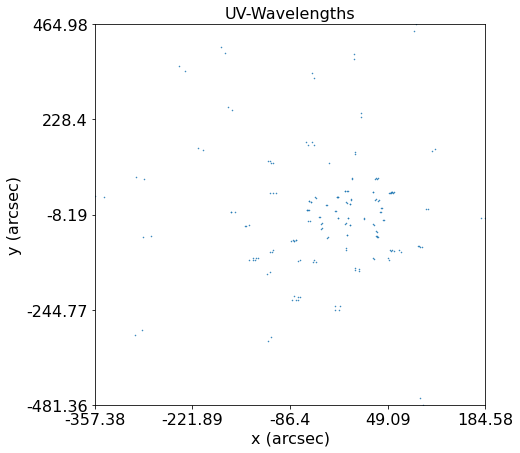

In [3]:
interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.figures(visibilities=True, uv_wavelengths=True)

Although interferometer lens modeling is performed in the uv-plane and therefore Fourier space, we still need to define
a `real-space mask`. This mask defines the grid on which the image of the lensed source galaxy is computed via a
_Tracer_, which when we fit it to data data in the uv-plane is mapped to Fourier space.

In [4]:
real_space_mask = al.Mask2D.circular(
    shape_native=(200, 200), pixel_scales=0.05, radius=3.0
)

To perform uv-plane modeling, **PyAutoLens** generates an image of the strong lens system in real-space via a `Tracer`. 

Lets quickly set up the `Tracer` we'll use in this example.

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


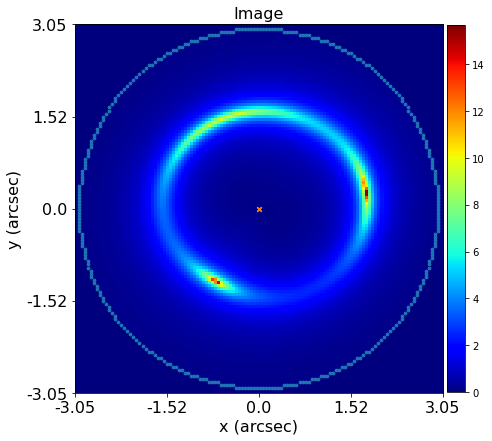

In [5]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.0, 0.05)),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

tracer_plotter = aplt.TracerPlotter(
    tracer=tracer, grid=real_space_mask.masked_grid_sub_1
)
tracer_plotter.figures(image=True)

To perform uv-plane modeling, **PyAutoLens** next Fourier transforms this image from real-sapce to the uv-plane.
This operation uses a *Transformer* object, of which there are multiple available in **PyAutoLens**. This includes
a direct Fourier transform which performs the exact Fourier transformw without approximation.

In [6]:
transformer_class = al.TransformerDFT

However, the direct Fourier transform is inefficient. For ~10 million visibilities, it requires **thousands of seconds**
to perform a single transform. To model a lens, we'll perform tens of thousands of transforms, making this approach
unfeasible for high quality ALMA and radio datasets.

For this reason, **PyAutoLens** supports the non-uniform fast fourier transform algorithm
**PyNUFFT** (https://github.com/jyhmiinlin/pynufft), which is significantly faster, being able too perform a Fourier
transform of ~10 million in less than a second!

In [7]:
transformer_class = al.TransformerNUFFT

The perform a fit, we follow the same process we did for imaging, creating a *MaskedInterferometer* object which 
behaves analogously to a `MaskImaging` object.

In [8]:
visibilities_mask = np.full(fill_value=False, shape=interferometer.visibilities.shape)

masked_interferometer = al.MaskedInterferometer(
    interferometer=interferometer,
    visibilities_mask=visibilities_mask,
    real_space_mask=real_space_mask,
    settings=al.SettingsMaskedInterferometer(transformer_class=transformer_class),
)

The masked interferometer can now be used with a *FitInterferometer* object to fit it to a data-set:

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/pynufft/linalg/nufft_cpu.py:300: ComplexWarning: Casting complex values to real discards the imaginary part
  output_x.ravel()[self.KdCPUorder * self.batch + bat] = xx.ravel()[


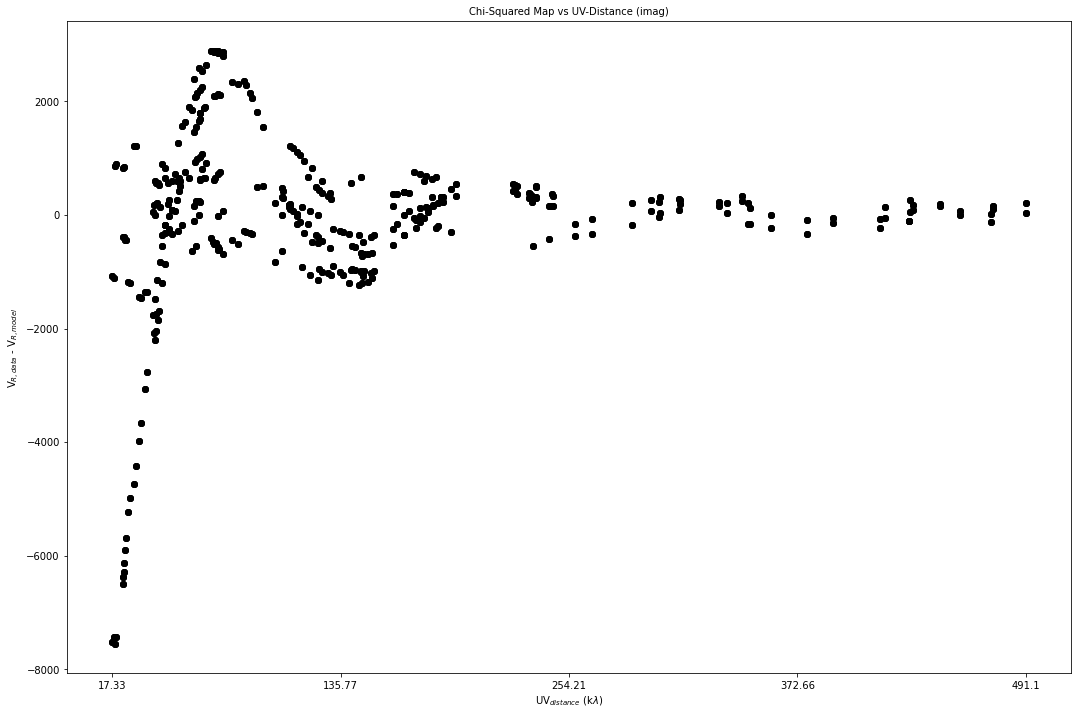

In [9]:
fit = al.FitInterferometer(masked_interferometer=masked_interferometer, tracer=tracer)

fit_interferometer_plotter = aplt.FitInterferometerPlotter(fit=fit)
fit_interferometer_plotter.subplot_fit_interferometer()

Interferometer data can also be modeled using pixelized source's, which again perform the source reconstruction by
directly fitting the visibilities in the uv-plane. The source reconstruction is visualized in real space:

Computing this source recontruction would be extremely inefficient if **PyAutoLens** used a traditional approach to
linear algebra which explicitly stored in memory the values required to solve for the source fluxes. In fact, for an
interferomter dataset of ~10 million visibilities this would require **hundreds of GB of memory**!

**PyAutoLens** uses the library **PyLops** (https://pylops.readthedocs.io/en/latest/) to represent this calculation as
a sequence of memory-light linear operators.

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/pynufft/linalg/nufft_cpu.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  xx.ravel()[self.NdCPUorder * self.batch + bat] = k.ravel()[
/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/pynufft/linalg/nufft_cpu.py:300: ComplexWarning: Casting complex values to real discards the imaginary part
  output_x.ravel()[self.KdCPUorder * self.batch + bat] = xx.ravel()[


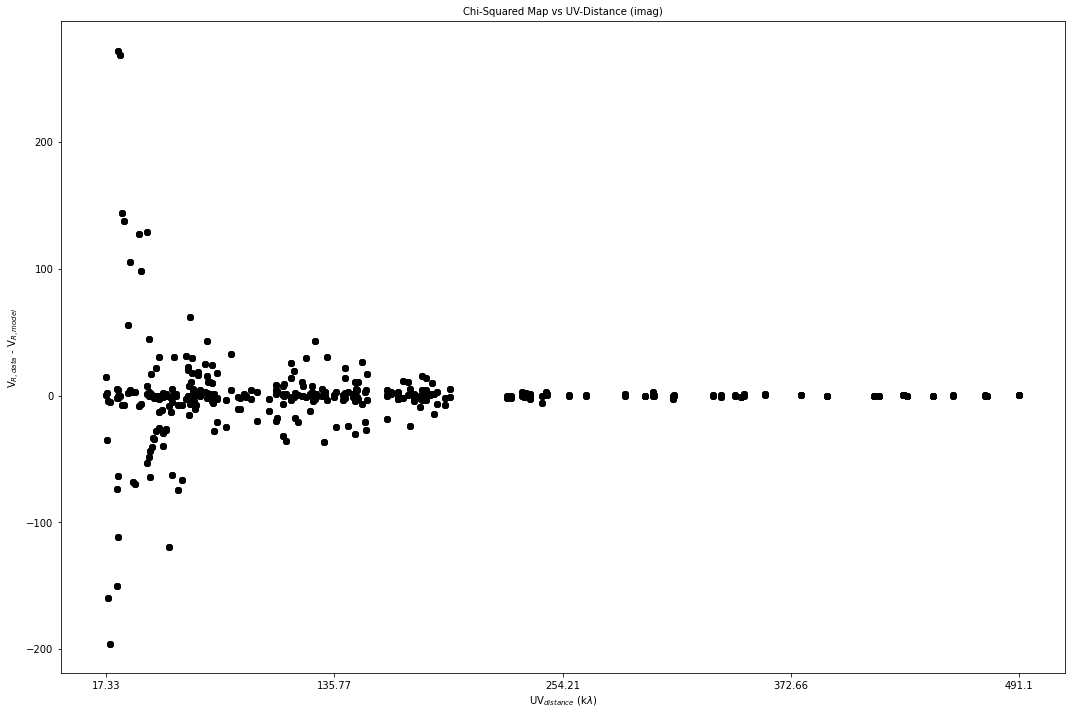

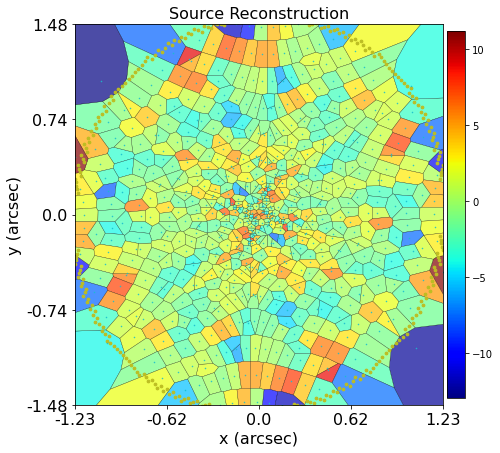

In [10]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
    regularization=al.reg.Constant(coefficient=1.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitInterferometer(
    masked_interferometer=masked_interferometer,
    tracer=tracer,
    settings_inversion=al.SettingsInversion(use_linear_operators=True),
)

fit_interferometer_plotter = aplt.FitInterferometerPlotter(fit=fit)
fit_interferometer_plotter.subplot_fit_interferometer()

inversion_plotter = aplt.InversionPlotter(inversion=fit.inversion)
inversion_plotter.figures(reconstruction=True)

Finish.